<a href="https://colab.research.google.com/github/virajchandugade/sentimental_analysis/blob/master/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q datasets transformers
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", 

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
!git lfs install

!git config --global credential.helper store


Git LFS initialized.


In [6]:
from datasets import load_dataset
dataset = load_dataset('Robotkid2696/food_classification')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/1998 [00:00<?, ?it/s]

In [7]:
dataset = dataset['train']

In [8]:
data = dataset.train_test_split(test_size=0.15)

In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1698
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
})

In [10]:
ex = data['train'][500]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x436>,
 'label': 2}

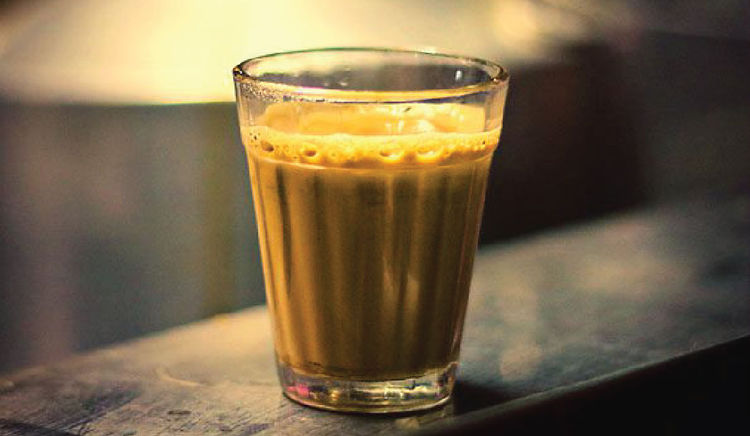

In [11]:
image = ex['image']
image

In [12]:
labels = data['train'].features['label']
labels

ClassLabel(names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [13]:
labels.int2str(ex['label'])

'chai'

In [14]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-14-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [15]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [16]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

# Assuming feature_extractor.size is a dictionary with 'height' and 'width'
size = feature_extractor.size['height']  # Or 'width', depending on your use case

# Define transformations with integer size
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


In [18]:
train_ds = data['train']
val_ds = data['test']

# Apply transformations to datasets
train_ds = train_ds.with_transform(preprocess_train)
val_ds = val_ds.with_transform(preprocess_val)

# Print some examples to verify
print(train_ds[0])
print(val_ds[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=780x439 at 0x793308C83A00>, 'label': 14, 'pixel_values': tensor([[[-0.6000, -0.6000, -0.6000,  ...,  0.4902,  0.4667,  0.4118],
         [-0.6000, -0.6000, -0.6000,  ...,  0.4980,  0.4745,  0.4510],
         [-0.6157, -0.6078, -0.6000,  ...,  0.4353,  0.4118,  0.3961],
         ...,
         [-0.8039, -0.7882, -0.7725,  ...,  0.5373,  0.6863,  0.6392],
         [-0.8039, -0.7882, -0.7725,  ...,  0.7490,  0.8588,  0.7961],
         [-0.8039, -0.7882, -0.7725,  ...,  0.8510,  0.8667,  0.8275]],

        [[-0.9137, -0.9137, -0.9137,  ...,  0.0902,  0.0667,  0.0118],
         [-0.9059, -0.9059, -0.9059,  ...,  0.1294,  0.1059,  0.0824],
         [-0.9216, -0.9137, -0.8980,  ...,  0.0824,  0.0588,  0.0431],
         ...,
         [-1.0000, -0.9922, -0.9765,  ...,  0.4353,  0.5922,  0.5529],
         [-1.0000, -0.9922, -0.9765,  ...,  0.6627,  0.7804,  0.7255],
         [-1.0000, -0.9922, -0.9765,  ...,  0.7647,  0.7882,  0.756

model training

In [19]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'finetuned-indian-food',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [22]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [23]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [24]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1722418686.65ff44f43e93.4984.0:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 490257986GF
  train_loss               =      0.6256
  train_runtime            =  3:42:59.04
  train_samples_per_second =       0.508
  train_steps_per_second   =       0.032


In [25]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9633
  eval_loss               =     0.2086
  eval_runtime            = 0:03:19.55
  eval_samples_per_second =      1.503
  eval_steps_per_second   =       0.19


In [26]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'indian_food_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1722432438.65ff44f43e93.4984.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

test new image

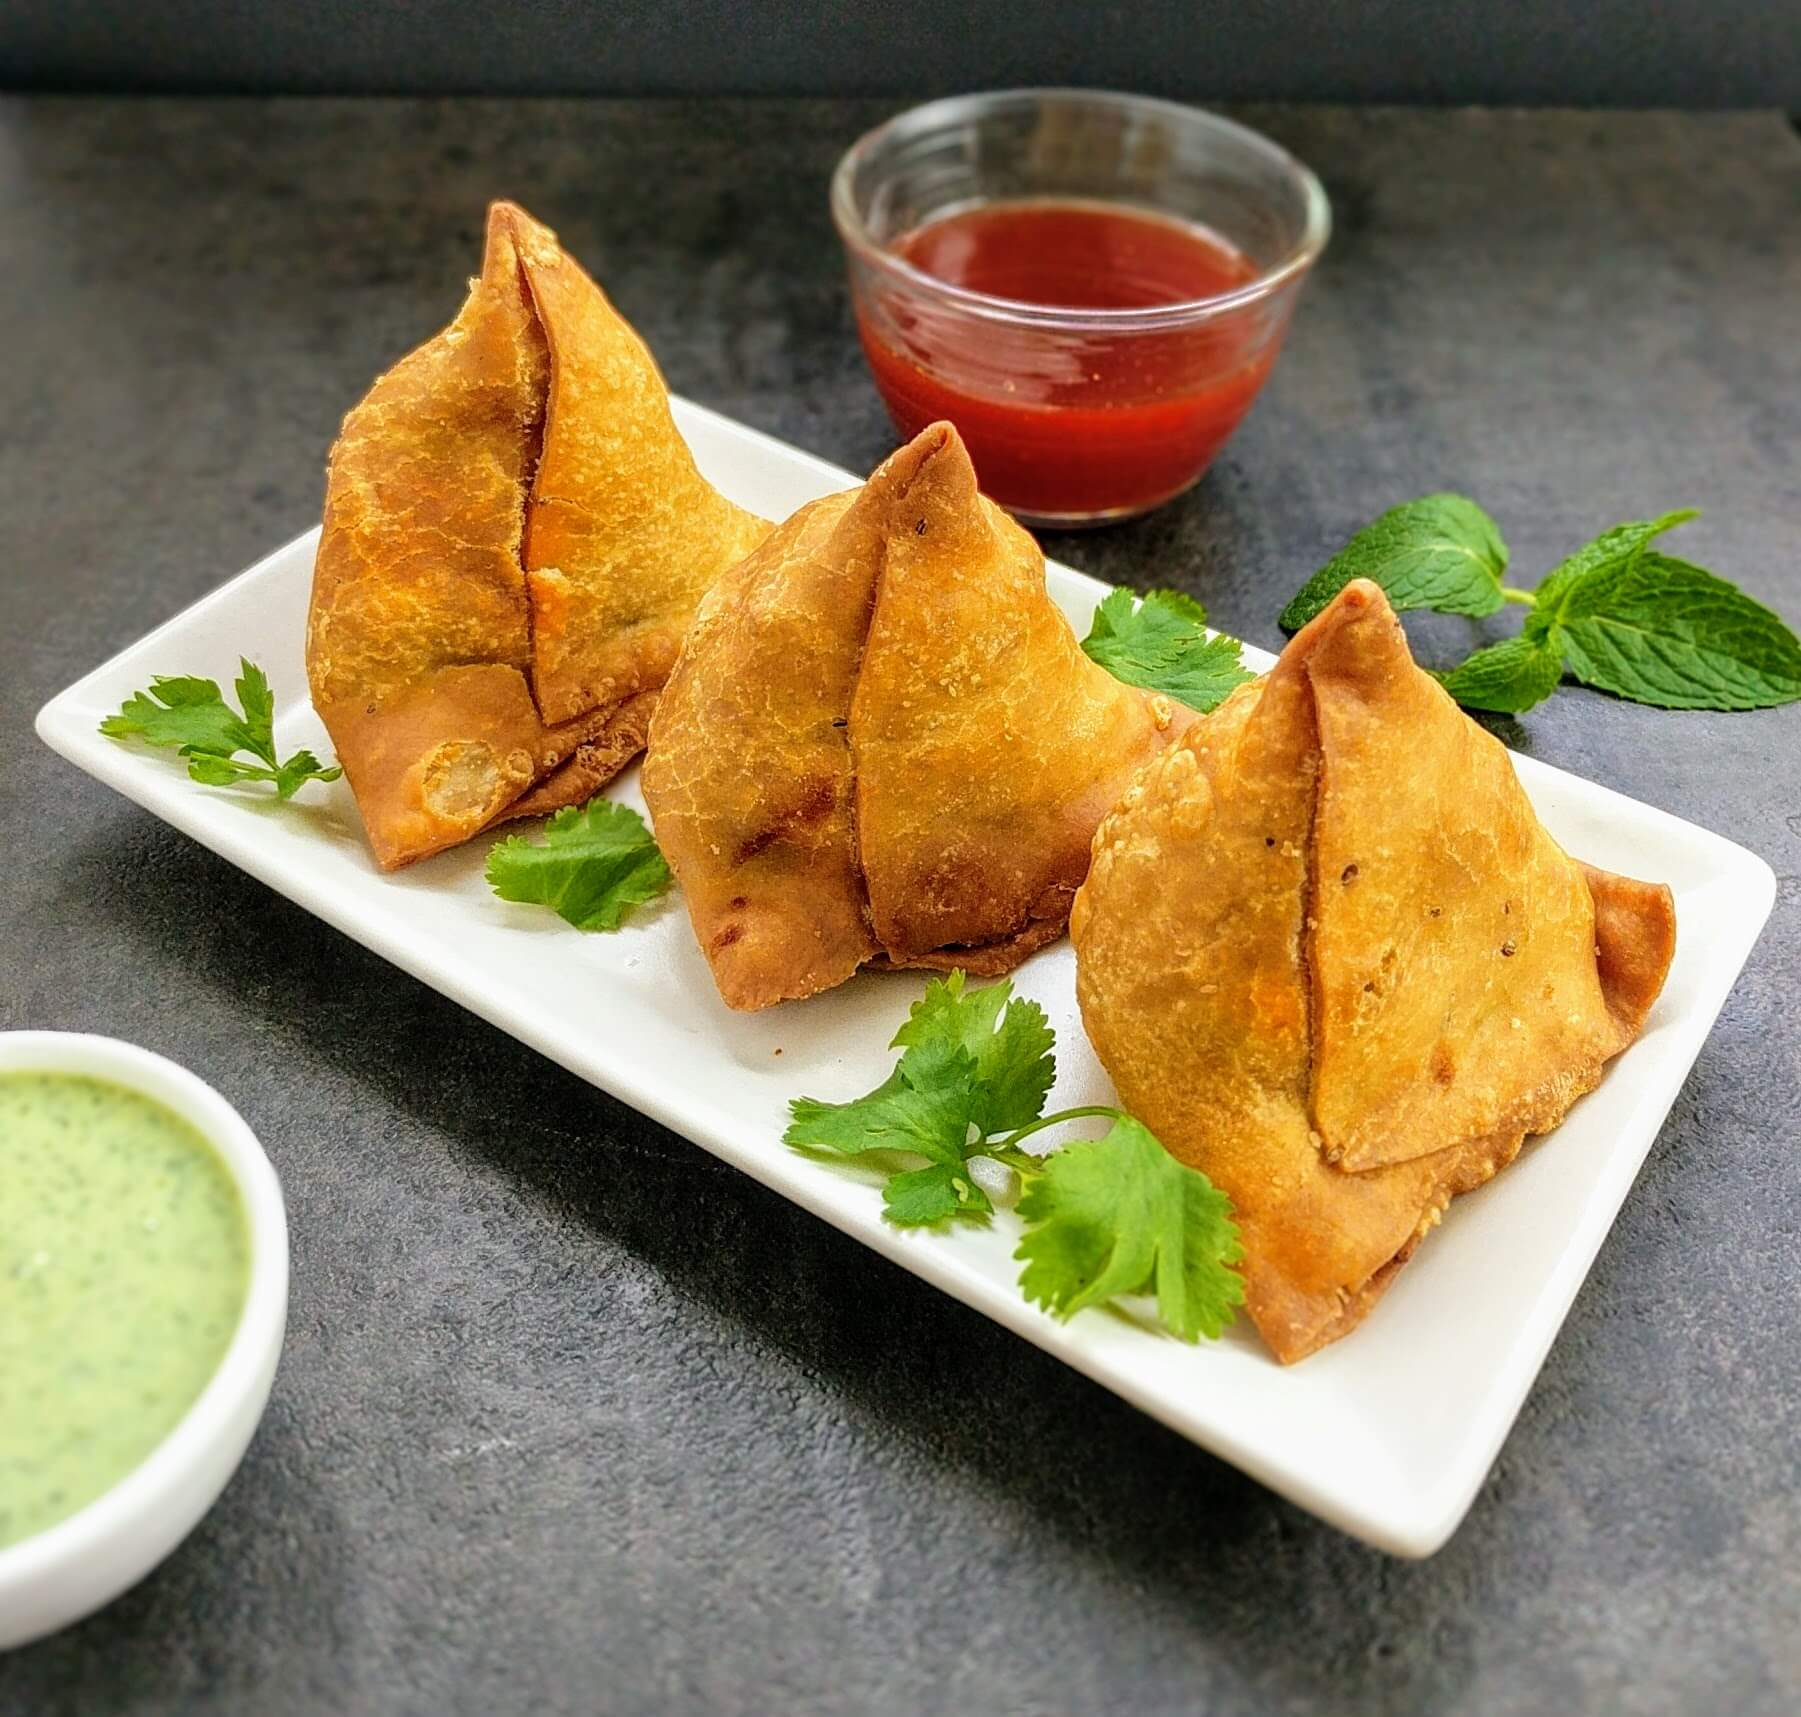

In [41]:
from PIL import Image
import requests

url = 'https://huggingface.co/Robotkid2696/finetuned-indian-food/resolve/main/samosa-recipe-step-by-step-instructions.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [42]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "Robotkid2696/finetuned-indian-food"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [43]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [44]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [45]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: samosa
